In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
%matplotlib widget

### Read MEG data and metadata

In [2]:
epochs = mne.read_epochs("/Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-pushmi_split-01_epo.fif", preload=True)

Reading /Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-pushmi_split-01_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Reading /Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-pushmi_split-01_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 20 columns
7110 matching events found
No baseline correction applied
0 projection items activated


In [3]:
# meta = epochs.metadata.copy()
# sfreq = epochs.info["sfreq"]
# onset_sec = epochs.events[:, 0] / sfreq
# meta = meta.assign(onset_sec=onset_sec)

In [ ]:
byhand = pd.read_csv("byhand.csv")
behavior = pd.read_csv("/Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/Behavior/sub-01/data.xpd", 
                       comment="#").query("trial_type == 'test'")

behavior["trial_number"] = (behavior["trial_number"] - 1) % 32 + 1

merged = pd.merge(
    byhand[["event_name", "trial_number", "trial_block"]],
    behavior.drop(columns=["ID", "trial_type"]),
    on=["trial_number", "trial_block"],
    how="left"
)

In [5]:
md = pd.read_csv("metadata.csv").reset_index().drop("index", axis=1)
epochs.metadata = md.copy()

Replacing existing metadata with 30 columns


In [7]:
epochs.metadata

,subject_id,trial_number,trial_block,event_name,stim,assigned,assigned_category,assignment_order,shape1,shape2,...,movement,outcome,ground_truth,change,test_sentence,correct_key,timestamp,participant_response,reaction_time,participant_correct
0,5,1,1,initial_fixation,fixationCross,NaN,NaN,symbol_first,croix,losenge,...,right,tire,La biche tire la lampe,agent,La dinde tire la lampe,f,1999444,f,570.0,True
1,5,1,1,assignment_1_shape,croix,no,NaN,symbol_first,croix,losenge,...,right,tire,La biche tire la lampe,agent,La dinde tire la lampe,f,1999444,f,570.0,True
2,5,1,1,assignment_1_label,lampe,NaN,NaN,symbol_first,croix,losenge,...,right,tire,La biche tire la lampe,agent,La dinde tire la lampe,f,1999444,f,570.0,True
3,5,1,1,inter_assignment_fixation,fixationCross,NaN,NaN,symbol_first,croix,losenge,...,right,tire,La biche tire la lampe,agent,La dinde tire la lampe,f,1999444,f,570.0,True
4,5,1,1,assignment_2_shape,losenge,no,NaN,symbol_first,croix,losenge,...,right,tire,La biche tire la lampe,agent,La dinde tire la lampe,f,1999444,f,570.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7251,5,32,12,test_sentence_2,dinde,NaN,NaN,symbol_first,cercle,losenge,...,left,pousse,La dinde pousse la lampe,patient,La dinde pousse la pince,f,8229013,f,529.0,True
7252,5,32,12,test_sentence_3,pousse,NaN,NaN,symbol_first,cercle,losenge,...,left,pousse,La dinde pousse la lampe,patient,La dinde pousse la pince,f,8229013,f,529.0,True
7253,5,32,12,test_sentence_4,la,NaN,NaN,symbol_first,cercle,losenge,...,left,pousse,La dinde pousse la lampe,patient,La dinde pousse la pince,f,8229013,f,529.0,True
7254,5,32,12,test_sentence_5,pince,NaN,NaN,symbol_first,cercle,losenge,...,left,pousse,La dinde pousse la lampe,patient,La dinde pousse la pince,f,8229013,f,529.0,True


In [8]:
# Subset only central_location_flash rows
central = md.loc[md["event_name"] == "central_location_flash", ["stim", "assigned_category"]]

# Count frequencies of each unique (stim, assigned) combination
combo_counts = central.value_counts().reset_index(name="count")

print(combo_counts)

      stim assigned_category  count
0   cercle              tool     48
1   cercle            animal     47
2    croix            animal     47
3    croix              tool     47
4  losenge            animal     47
5   carré            animal     46
6   carré              tool     46
7  losenge              tool     46


In [9]:
# Work only on central_location_flash events
mask_central = md["event_name"] == "central_location_flash"
central_md = md.loc[mask_central].copy()

# Define categories as stim-assigned pairs
central_md["category"] = central_md["stim"].astype(str) + "_" + central_md["assigned_category"].astype(str)

# Container for splits
split1_idx, split2_idx = [], []

rng = np.random.default_rng(seed=42)  # set seed for reproducibility

# Iterate over each category
for cat, group in central_md.groupby("category"):
    n = len(group)
    # Random permutation of indices
    shuffled = rng.permutation(group.index)
    half = n // 2
    idx1 = shuffled[:half]
    idx2 = shuffled[half:]
    split1_idx.extend(idx1)
    split2_idx.extend(idx2)

# Create new Epochs objects for the two halves
epochs_split1 = epochs[split1_idx]
epochs_split2 = epochs[split2_idx]

print("Split 1 size:", len(epochs_split1))
print("Split 2 size:", len(epochs_split2))

Split 1 size: 185
Split 2 size: 189


In [10]:
def rdm_at_index(epochs_split1, epochs_split2, time_index,
                 event_name="central_location_flash",
                 factor_cols=("stim", "assigned_category"),
                 by="shapes",
                 picks=None):
    """
    Compute cross-validated similarity (1 - correlation) at a given time index.
    Returns (S, labels) where S is (n_cat, n_cat).
    """
    def mean_patterns(epochs):
        md = epochs.metadata
        ep = epochs[md["event_name"].eq(event_name)]
        if picks is not None:
            ep = ep.copy().pick(picks)
        data = ep.get_data()  # (n_epochs, n_channels, n_times)
        mds  = ep.metadata.copy()
        mds["stim_assigned"] = (
            mds[factor_cols[0]].astype(str) + "_" + mds[factor_cols[1]].astype(str)
        ) if by == "shapes" else (
            mds[factor_cols[1]].astype(str) + "_" + mds[factor_cols[0]].astype(str)
        )
        labels = mds["stim_assigned"].to_numpy()
        cats = pd.Index(sorted(pd.unique(labels)))

        means = []
        for cat in cats:
            idx = np.where(labels == cat)[0]
            means.append(data[idx, :, time_index].mean(axis=0))
        return list(cats), np.vstack(means)  # (n_cat, n_channels)

    labels1, X1 = mean_patterns(epochs_split1)
    labels2, X2 = mean_patterns(epochs_split2)

    # align category order across splits
    if labels1 != labels2:
        cats = sorted(set(labels1) & set(labels2))
        def reorder(labels, X, cats):
            li = {lbl: i for i, lbl in enumerate(labels)}
            return np.vstack([X[li[c]] for c in cats]), cats
        X1, cats = reorder(labels1, X1, cats)
        X2, _    = reorder(labels2, X2, cats)
        labels = cats
    else:
        labels = labels1

    # correlation distance, then convert to similarity
    D = pairwise_distances(X1, X2, metric="correlation")  # (n_cat, n_cat)
    S = 1.0 - D
    return S, labels

RDM, cats = rdm_at_index(epochs_split1, epochs_split2, time_index=0, picks="mag")

In [11]:
cats

['carré_animal',
 'carré_tool',
 'cercle_animal',
 'cercle_tool',
 'croix_animal',
 'croix_tool',
 'losenge_animal',
 'losenge_tool']

In [24]:
def plot_rdm_with_time(S, labels, time_ms, ax=None):
    """
    Plot similarity matrix S with title 'Time = {time_ms}' (ms).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(S, interpolation="nearest", vmin=0, vmax=1)
    ax.figure.colorbar(im, ax=ax, label="Similarity (1 - correlation)")

    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    ax.set_title(f"Time = {int(round(time_ms))} ms")
    ax.set_xlabel("Split B categories"); ax.set_ylabel("Split A categories")
    ax.figure.tight_layout()
    return im, ax

In [22]:
from ipywidgets import IntSlider, VBox
from IPython.display import display

def rdm_widget(epochs_split1, epochs_split2, picks="mag",
               event_name="central_location_flash",
               factor_cols=("stim", "assigned_category"),
               start_index=0, by="shapes"):
    """
    Make an interactive slider to browse RDM by integer time index.
    Assumes epochs have 301 time samples (0..300), e.g., -200 to 1000 ms.
    """
    times = epochs_split1.times  # seconds
    n_idx = len(times)
    slider = IntSlider(description="Time idx", min=0, max=n_idx-1, step=1, value=start_index, continuous_update=False)

    # initial compute & figure
    S0, labels = rdm_at_index(epochs_split1, epochs_split2, start_index,
                              event_name=event_name, factor_cols=factor_cols, picks=picks, by=by)
    fig, ax = plt.subplots(figsize=(6,5))
    im, ax = plot_rdm_with_time(S0, labels, time_ms=times[start_index]*1000, ax=ax)

    def on_change(change):
        if change["name"] == "value":
            idx = change["new"]
            S, _ = rdm_at_index(epochs_split1, epochs_split2, idx,
                                event_name=event_name, factor_cols=factor_cols, picks=picks)
            im.set_data(S)
            im.set_clim(0, 1)
            ax.set_title(f"Time = {int(round(times[idx]*1000))} ms")
            ax.figure.canvas.draw_idle()

    slider.observe(on_change, names="value")
    display(VBox([slider]))
    plt.show()
    return {"figure": fig, "ax": ax, "image": im, "slider": slider}

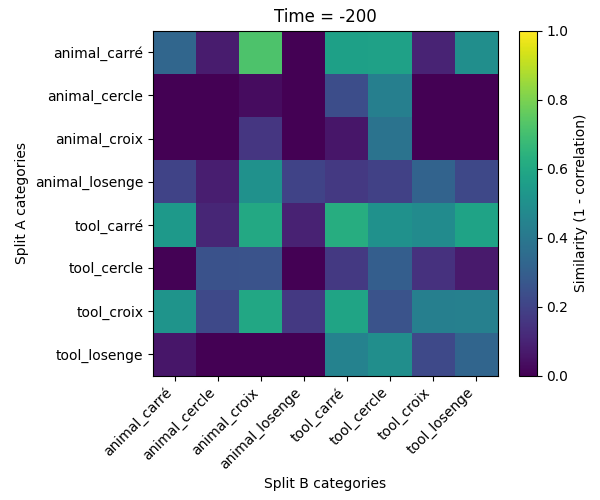

In [23]:

ui_categories = rdm_widget(epochs_split1, epochs_split2, picks="mag", start_index=0, by="categories")